#### Reference :
* Submission reference https://www.kaggle.com/arnabs007/apple-leaf-diseases-with-inceptionresnetv2-keras

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
os.listdir('/kaggle/input/plant-pathology-2021-fgvc8/')

['sample_submission.csv', 'train_images', 'train.csv', 'test_images']

In [3]:
import pandas as pd
import numpy as np
import os
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet169, Xception
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

plt.style.use('seaborn')
%matplotlib inline

In [4]:
train_df = pd.read_csv('/kaggle/input/plant-pathology-2021-fgvc8/train.csv')
test_df = pd.read_csv('/kaggle/input/plant-pathology-2021-fgvc8/sample_submission.csv')
print("Dataset Shape: ",train_df.shape)
train_df.head()

Dataset Shape:  (18632, 2)


,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [5]:
datapath = glob('/kaggle/input/plant-pathology-2021-fgvc8/train_images/*')
print("Image Datasets Shape: ", len(datapath))

Image Datasets Shape:  18632


In [6]:
def add_link(path):
    return_path ='/kaggle/input/plant-pathology-2021-fgvc8/train_images/'+str(path)
    return return_path

In [7]:
def add_link_test(path):
    return_path ='/kaggle/input/plant-pathology-2021-fgvc8/test_images/'+str(path)
    return return_path

In [8]:
train_df['image'] = train_df['image'].apply(lambda x: add_link(x))
train_df.head()

,image,labels
0,/kaggle/input/plant-pathology-2021-fgvc8/train...,healthy
1,/kaggle/input/plant-pathology-2021-fgvc8/train...,scab frog_eye_leaf_spot complex
2,/kaggle/input/plant-pathology-2021-fgvc8/train...,scab
3,/kaggle/input/plant-pathology-2021-fgvc8/train...,scab
4,/kaggle/input/plant-pathology-2021-fgvc8/train...,complex


In [9]:
test_df['image'] = test_df['image'].apply(lambda x: add_link_test(x))
test_df.head()

,image,labels
0,/kaggle/input/plant-pathology-2021-fgvc8/test_...,healthy
1,/kaggle/input/plant-pathology-2021-fgvc8/test_...,healthy
2,/kaggle/input/plant-pathology-2021-fgvc8/test_...,healthy


# EDA
* Labels per Value Percent
* Plot Sample Images

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


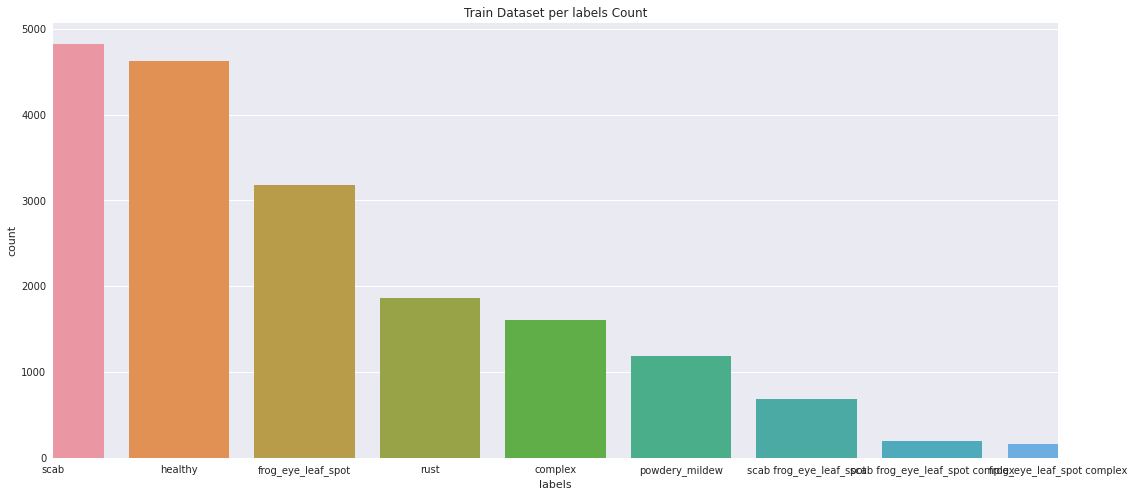

In [10]:
f,ax = plt.subplots(1,1,figsize=(18,8))
ax = sns.countplot(train_df['labels'], order=train_df['labels'].value_counts().sort_values(ascending=False).index)
ax.set_xlim(0,8)
ax.set_title('Train Dataset per labels Count')
plt.show()

In [11]:
unique_list = np.unique(train_df['labels'])
print(unique_list)
print(train_df['labels'].value_counts().count())

['complex' 'frog_eye_leaf_spot' 'frog_eye_leaf_spot complex' 'healthy'
 'powdery_mildew' 'powdery_mildew complex' 'rust' 'rust complex'
 'rust frog_eye_leaf_spot' 'scab' 'scab frog_eye_leaf_spot'
 'scab frog_eye_leaf_spot complex']
12


In [12]:
def read_image(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile, dtype = tf.float32)
    return image

In [13]:
def get_label(path):
    return_label = train_df[train_df['image']==path]['labels']
    print(return_label)
    return list(return_label)

In [14]:
def get_label_image(path):
    label = get_label(path)
    image = read_image(path)
    return label, image

1881    complex
Name: labels, dtype: object


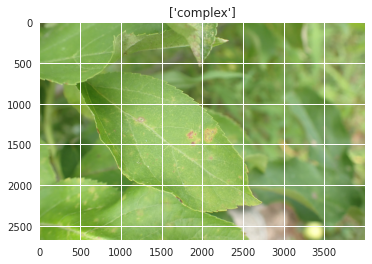

11261    healthy
Name: labels, dtype: object


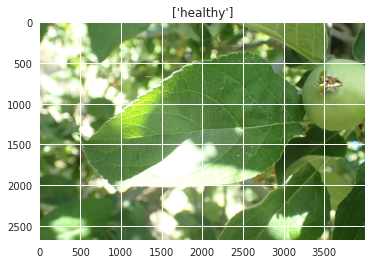

1856    scab
Name: labels, dtype: object


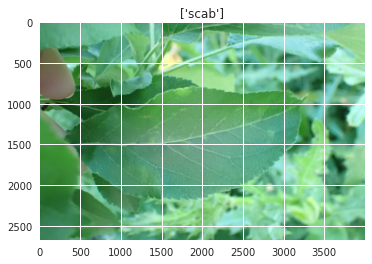

40    healthy
Name: labels, dtype: object


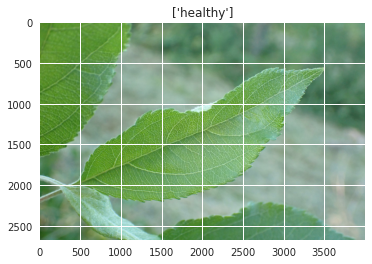

12781    healthy
Name: labels, dtype: object


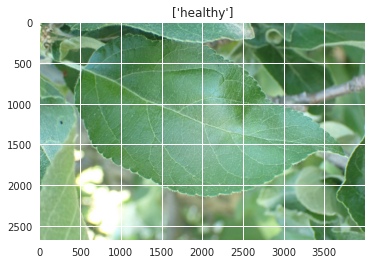

In [15]:
index_list = np.random.randint(128, size=5)
for i in index_list:
    path = datapath[i]
    sample_label, sample_image = get_label_image(path)

    plt.imshow(sample_image)
    plt.title(sample_label)
    plt.show()

# Feature Engineering
* Split Train / Validation Data
* Image Data Generate

In [16]:
INPUT_SIZE = (256,256,3)
BATCH_SIZE = 32
CLASSES = train_df['labels'].unique().tolist() # 12

In [17]:
train_data, val_data = train_test_split(train_df, test_size=0.2)
print('Train Data Shape: ',train_data.shape)
print('Validation Data Shape: ',val_data.shape)

Train Data Shape:  (14905, 2)
Validation Data Shape:  (3727, 2)


In [18]:
train_datagen = ImageDataGenerator(
    rescale = 1/255.,
    width_shift_range = 0.3, 
    zoom_range=0.2, 
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(
    rescale = 1/255.
)

val_datagen = ImageDataGenerator(
    rescale = 1/255.
)

In [19]:
train_generator = train_datagen.flow_from_dataframe(
    train_data,
    classes=CLASSES,
    x_col='image',
    y_col='labels',
    target_size=INPUT_SIZE[:2]
)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    classes=CLASSES,
    x_col='image',
    y_col='labels',
    target_size=INPUT_SIZE[:2]
)
val_generator = val_datagen.flow_from_dataframe(
    val_data,
    classes=CLASSES,
    x_col='image',
    y_col='labels',
    target_size=INPUT_SIZE[:2]
)

Found 14905 validated image filenames belonging to 12 classes.
Found 3 validated image filenames belonging to 12 classes.
Found 3727 validated image filenames belonging to 12 classes.


# Modeling
* Xception

In [20]:
weights_path = "../input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [21]:
pre_model = Xception(include_top=False, weights=weights_path, input_shape=INPUT_SIZE)

In [22]:
model = tf.keras.Sequential()
model.add(pre_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(12, activation='softmax'))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               67109376  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 12)                3084      
Total params: 88,105,268
Trainable params: 88,050,740
Non-trainable params: 54,528
_______________________________________

In [24]:
callback= ReduceLROnPlateau(monitor='val_loss',
                       factor=.01, 
                       patience=3, 
                       min_lr=1e-5) 

In [25]:
model.compile(optimizer =keras.optimizers.SGD(lr=0.001,momentum=.9,nesterov=False),
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

In [26]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator)//BATCH_SIZE,
    epochs=25,
    validation_data=val_generator,
    validation_steps=len(val_generator)//BATCH_SIZE,
    callbacks=[callback]
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
14/14 [==============================] - 106s 7s/step - loss: 2.1922 - accuracy: 0.2285 - val_loss: 2.0423 - val_accuracy: 0.2500
Epoch 2/25
14/14 [==============================] - 99s 7s/step - loss: 1.7860 - accuracy: 0.3553 - val_loss: 2.2527 - val_accuracy: 0.3021
Epoch 3/25
14/14 [==============================] - 99s 7s/step - loss: 1.8116 - accuracy: 0.3894 - val_loss: 1.8104 - val_accuracy: 0.2917
Epoch 4/25
14/14 [==============================] - 98s 7s/step - loss: 1.6493 - accuracy: 0.4037 - val_loss: 1.9817 - val_accuracy: 0.3021
Epoch 5/25
14/14 [==============================] - 97s 7s/step - loss: 1.5435 - accuracy: 0.4874 - val_loss: 1.8561 - val_accuracy: 0.4583
Epoch 6/25
14/14 [==============================] - 100s 7s/step - loss: 1.4182 - accuracy: 0.4924 - val_loss: 1.2826 - val_accuracy: 0.5938
Epoch 7/25
14/14 [==============================] - 96s 7s/step - loss: 1.2803 - accuracy: 0.5811 - val_loss: 2.0328 - val_accuracy: 0.3438
Epoch 8/25
14/14 [

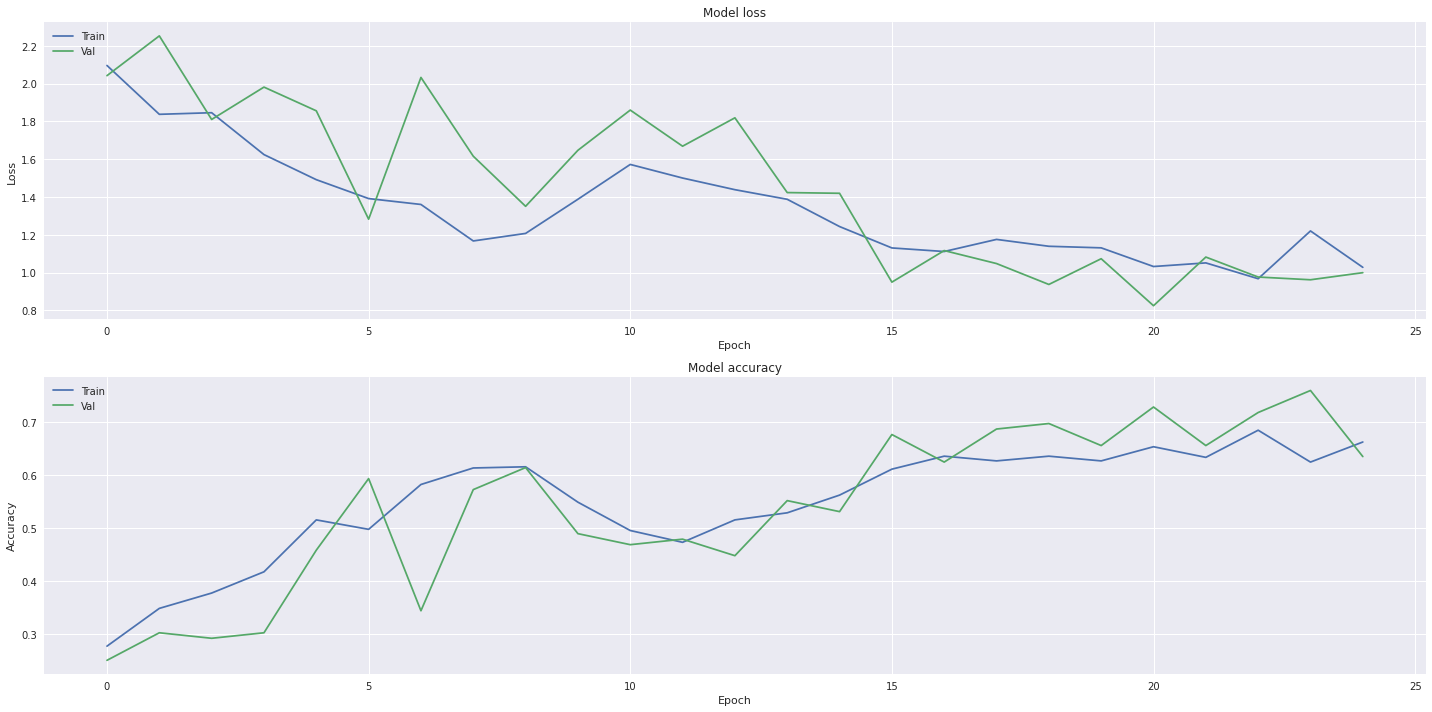

In [27]:
f,ax = plt.subplots(2,1,figsize=(20,10))
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Val'], loc='upper left')

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Val'], loc='upper left')

f.tight_layout()
plt.show()

# Submission

In [28]:
submission = pd.read_csv('/kaggle/input/plant-pathology-2021-fgvc8/sample_submission.csv')
submission.head()

,image,labels
0,85f8cb619c66b863.jpg,healthy
1,ad8770db05586b59.jpg,healthy
2,c7b03e718489f3ca.jpg,healthy


In [29]:
def get_key(val):
    for key, value in train_generator.class_indices.items():
        if val == value:
            return key

In [30]:
preds = model.predict(test_generator)
print(preds)
preds = preds.tolist()

for i in range(len(preds)):
    preds[i] = np.argmax(preds[i])
print(preds)

for i in range(len(preds)):
    preds[i] = get_key(preds[i])
print(preds)

[[0.39698416 0.04622006 0.00574452 0.00131488 0.00844284 0.0067843
  0.02505914 0.00964412 0.00925751 0.17289992 0.29064277 0.02700574]
 [0.10557374 0.4757014  0.00928643 0.00096002 0.00113566 0.00249199
  0.33407676 0.01269993 0.00742306 0.00224514 0.03718444 0.01122134]
 [0.12693387 0.07485161 0.00667239 0.08716535 0.02155312 0.01243491
  0.05724328 0.01114756 0.00303641 0.52954054 0.06454304 0.00487793]]
[0, 1, 9]
['complex', 'frog_eye_leaf_spot', 'scab']


In [31]:
submission['labels'] = preds

In [32]:
submission.to_csv('submission.csv',index=False)